# American Sign Language Detection

Author: Henry Hong

In [35]:
%pip install opencv-python mediapipe

Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the training and testing data
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

# Separate labels from features
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

# One-hot encode labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

# Normalize pixel values and reshape
x_train = train_df.values / 255.0
x_test = test_df.values / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

# Define the CNN model
model = Sequential([
    Conv2D(75, (3,3), strides=1, padding='same', activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(50, (3,3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(25, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(24, activation='softmax')  # 24 classes for A-Y, excluding J and Z
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=20, validation_data=(x_test, y_test))

# Save the trained model
model.save('smnist.h5')


Epoch 1/20


/Users/henryhong/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/henryhong/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.4798 - loss: 1.7338 - val_accuracy: 0.1464 - val_loss: 3.8237
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.9153 - loss: 0.2590 - val_accuracy: 0.5066 - val_loss: 1.6500
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.9649 - loss: 0.1125 - val_accuracy: 0.9795 - val_loss: 0.0819
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9767 - loss: 0.0787 - val_accuracy: 0.9631 - val_loss: 0.0985
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9852 - loss: 0.0474 - val_accuracy: 0.9682 - val_loss: 0.0857
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9893 - loss: 0.0358 - val_accuracy: 0.9378 - val_loss: 0.1898
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.9912 - loss: 0.0289 - val_accuracy: 0.9320 - val_loss: 0.2078
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9916 - loss: 0.0277 - val_accurac

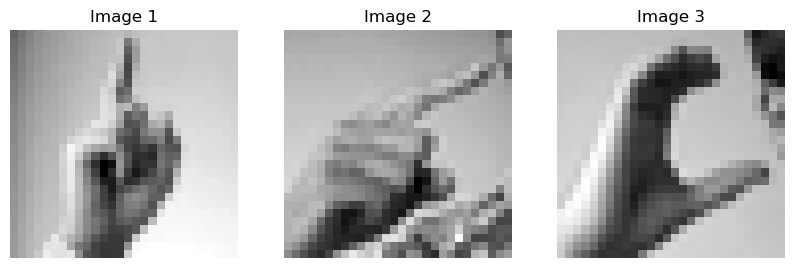

In [66]:
# Create a subplot with 1 row and 3 columns for the first three images
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Loop through the first three images and plot each one
for i in range(3):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')  # Turn off the axis

# Display the plot
plt.show()


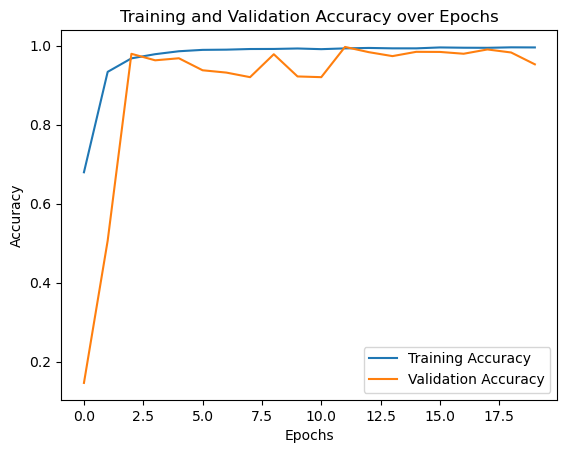

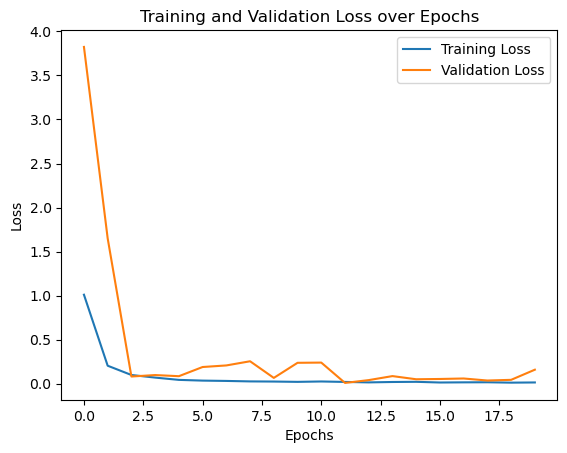

In [52]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy over Epochs")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

In [ ]:
import os
import tensorflow as tf
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import time
from keras.models import load_model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the trained ASL model
model = load_model('smnist.h5')

# Initialize MediaPipe for hand detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

# Set up the webcam feed
cap = cv2.VideoCapture(1)
_, frame = cap.read()
h, w, c = frame.shape

# Letter predictions
letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Function to preprocess the hand region for model prediction
def preprocess_hand_region(hand_region):
    hand_region = cv2.cvtColor(hand_region, cv2.COLOR_BGR2GRAY)      # Convert to grayscale
    hand_region = cv2.resize(hand_region, (28, 28))                  # Resize to 28x28
    hand_region = hand_region / 255.0                                # Normalize pixel values
    hand_region = hand_region.reshape(1, 28, 28, 1)                  # Reshape for model
    return hand_region

# Main loop for real-time ASL recognition
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing without flipping
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(frame_rgb)

    # Check for detected hand landmarks
    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            # Calculate bounding box around the hand
            x_min, y_min, x_max, y_max = w, h, 0, 0
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)

            # Expand the bounding box slightly
            x_min, y_min = max(0, x_min - 20), max(0, y_min - 20)
            x_max, y_max = min(w, x_max + 20), min(h, y_max + 20)

            # Draw bounding box and hand landmarks on the frame
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract and preprocess the hand region
            hand_region = frame[y_min:y_max, x_min:x_max]
            if hand_region.size > 0:
                hand_region_preprocessed = preprocess_hand_region(hand_region)

                # Predict the ASL letter
                prediction = model.predict(hand_region_preprocessed)
                predarray = np.array(prediction[0])

                # Generate a dictionary with letters and their confidence levels
                letter_prediction_dict = {letterpred[i]: predarray[i] for i in range(len(letterpred))}
                sorted_predictions = sorted(letter_prediction_dict.items(), key=lambda x: x[1], reverse=True)
                
                # Get top 3 predictions with confidence
                top1, top2, top3 = sorted_predictions[:3]
                print(f"Predicted Character 1: {top1[0]}, Confidence 1: {top1[1] * 100:.2f}%")
                print(f"Predicted Character 2: {top2[0]}, Confidence 2: {top2[1] * 100:.2f}%")
                print(f"Predicted Character 3: {top3[0]}, Confidence 3: {top3[1] * 100:.2f}%")

                # Display the top prediction on the frame
                cv2.putText(frame, f"{top1[0]} ({top1[1] * 100:.2f}%)", (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame with the drawn bounding box and predicted letter
    cv2.imshow("ASL Recognition", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1730755462.630578  752593 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1 Pro
W0000 00:00:1730755462.642458  834106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730755462.651559  834106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Character 1: P, Confidence 1: 95.80%
Predicted Character 2: F, Confidence 2: 1.90%
Predicted Character 3: I, Confidence 3: 1.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Character 1: F, Confidence 1: 100.00%
Predicted Character 2: C, Confidence 2: 0.00%
Predicted Character 3: W, Confidence 3: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Character 1: F, Confidence 1: 100.00%
Predicted Character 2: C, Confidence 2: 0.00%
Predicted Character 3: W, Confidence 3: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Character 1: F, Confidence 1: 100.00%
Predicted Character 2: I, Confidence 2: 0.00%
Predicted Character 3: W, Confidence 3: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Character 1: F, Confidence 1: 100.00%
Predicted Character 2: W, Confidence 2: 0.00%
Predicted Character 3: I, Confidence 3: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Character 1: F, Confidence 1: 100.00%
Predicted Character 2: I,

: 